### Load all the packages that we need

In [2]:
options(warn = -1)
library(caret)
library(dplyr)
library(corrplot)
library(DMwR)
library(unbalanced)
library(ROCR)
library(pROC)
library(boot)


### Set working directory and read data, change fraud status as factor, omit the site key and ordered product key which we do not need

In [3]:
setwd("/Users/sunmengnan/Documents/Github2/thgfd/data/stratified")
glm_data <- read.csv("dataset_11.csv")
glm_data$fraud_status <- as.factor((glm_data$fraud_status))
glm_data <- select(glm_data, -Site_Key, -Ordered_Product_Key)
head(glm_data)

Category_Level_2Accessories,Category_Level_2Bags,Category_Level_2Beauty.Boxes,Category_Level_2Body.Care,Category_Level_2Books,Category_Level_2Clothing,Category_Level_2DVD.and.Blu.Ray,Category_Level_2Footwear,Category_Level_2Fragrance,Category_Level_2Games,⋯,num_valid,count,prop,customer_status,canc_prop,ship_status,fraud_status,destination_int,priority_int,occupation_int
0,0,0,0,0,0,0,1,0,0,⋯,1,1,1,2,0,1,0,2,2,1
0,0,0,0,0,0,0,1,0,0,⋯,1,1,1,2,0,1,0,2,2,1
0,0,0,0,0,0,0,1,0,0,⋯,0,2,0,3,1,1,0,1,1,1
0,0,0,0,0,0,0,1,0,0,⋯,2,2,1,2,0,1,0,1,1,1
0,0,0,0,0,0,0,1,0,0,⋯,2,2,1,2,0,1,0,1,1,1
0,0,0,0,0,0,0,1,0,0,⋯,0,2,0,3,1,1,0,2,1,1


### select the data that we want to turn into factor type, turn all the variable type into factor, keep the factor which has more than two factor levels, then combine them together again

In [5]:
temp <- select(glm_data, -prop, -canc_prop, -Product_Charge_Price, -num_valid, 
               -count, -Order_Sequence_No, -Ordered_Qty, -Cancelled_Qty)
temp[,(1:ncol(temp))] <- lapply(temp[,(1:ncol(temp))],as.factor)
temp <- temp[, sapply(temp, nlevels) > 1]
nums <- select(glm_data, prop, canc_prop, Product_Charge_Price, num_valid, 
               count, Order_Sequence_No, Ordered_Qty, Cancelled_Qty)
glm_data <- cbind(temp, nums)


### Omitting some conlumns which we do not need and view that top rows of the data 

In [6]:
glm_data <- select(glm_data, -Campaign_Key, -Delivery_Option_Type_Key, -Payment_Method_Key,
                   -Medium_Key, -pay_key_num, -Payment_Provider_Key, 
                   -Order_Payment_Status_Key, -occupation_int,
                   -canc_prop, -Ordered_Qty, -priority_int, -Cancelled_Qty, -prop,
                   -Order_Sequence_No, -count)
head(glm_data)

Category_Level_2Accessories,Category_Level_2Bags,Category_Level_2Clothing,Category_Level_2Footwear,Category_Level_2Gifting,customer_status,ship_status,fraud_status,destination_int,Product_Charge_Price,num_valid
0,0,0,1,0,2,1,0,2,59.40,1
0,0,0,1,0,2,1,0,2,45.90,1
0,0,0,1,0,3,1,0,1,54.95,0
0,0,0,1,0,2,1,0,1,11.00,2
0,0,0,1,0,2,1,0,1,48.00,2
0,0,0,1,0,3,1,0,2,54.95,0


### Omitting some columns again and form a new data frame

In [7]:
glm_data <- select(glm_data, -Category_Level_2Accessories, 
                   -Category_Level_2Bags, -Category_Level_2Gifting)

new_data <- glm_data

### Create a partition to seperate the data into training part and test part

In [15]:
set.seed(123)
index <- createDataPartition(glm_data$fraud_status, p = 0.7, list = FALSE)
train <- new_data[index, ]
test <- new_data[-index, ]


### Bulid a GLM model, using binomial logit link function, and also calculate the running time

In [16]:
start <- Sys.time()
model <- glm(fraud_status ~., data = train, family = binomial(link = "logit"))
end <- Sys.time()
time <- end - start
time
summary(model)

Time difference of 0.1106429 secs


Call:
glm(formula = fraud_status ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2809  -0.1366  -0.0951  -0.0895   3.4846  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.938861   0.659948  -1.423 0.154844    
Category_Level_2Clothing1  1.047219   0.701052   1.494 0.135232    
Category_Level_2Footwear1 -0.093587   0.645808  -0.145 0.884778    
customer_status2          -3.613580   0.277538 -13.020  < 2e-16 ***
customer_status3          -2.639656   0.390141  -6.766 1.32e-11 ***
customer_status4          -1.507553   0.275011  -5.482 4.21e-08 ***
ship_status2              -0.641700   0.440661  -1.456 0.145331    
destination_int2          -0.751565   0.214947  -3.497 0.000471 ***
Product_Charge_Price      -0.002829   0.003060  -0.925 0.355181    
num_valid                  0.032901   0.018025   1.825 0.067953 .  
---
Signif. codes:  0 ‘***’ 0.

### We can see that the customer status is very significant

### Then, choose a model by AIC in a Stepwise Algorithm, in this process, we gradually delete 2footwear, charge price and ship status, because these variables AIC are lower than others


In [17]:
model <- step(model)
summary(model)

Start:  AIC=843.7
fraud_status ~ Category_Level_2Clothing + Category_Level_2Footwear + 
    customer_status + ship_status + destination_int + Product_Charge_Price + 
    num_valid

                           Df Deviance     AIC
- Category_Level_2Footwear  1   823.72  841.72
- Product_Charge_Price      1   824.63  842.63
<none>                          823.70  843.70
- num_valid                 1   826.11  844.11
- ship_status               1   826.19  844.19
- Category_Level_2Clothing  1   826.27  844.27
- destination_int           1   835.87  853.87
- customer_status           3   988.29 1002.29

Step:  AIC=841.72
fraud_status ~ Category_Level_2Clothing + customer_status + ship_status + 
    destination_int + Product_Charge_Price + num_valid

                           Df Deviance     AIC
- Product_Charge_Price      1   824.70  840.70
<none>                          823.72  841.72
- num_valid                 1   826.14  842.14
- ship_status               1   826.21  842.21
- Category_


Call:
glm(formula = fraud_status ~ Category_Level_2Clothing + customer_status + 
    ship_status + destination_int + num_valid, family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2820  -0.1349  -0.0928  -0.0892   3.3252  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.20907    0.23475  -5.151 2.60e-07 ***
Category_Level_2Clothing1  1.31620    0.32052   4.106 4.02e-05 ***
customer_status2          -3.62189    0.27509 -13.166  < 2e-16 ***
customer_status3          -2.68273    0.38852  -6.905 5.02e-12 ***
customer_status4          -1.53690    0.27306  -5.628 1.82e-08 ***
ship_status2              -0.64894    0.44033  -1.474 0.140545    
destination_int2          -0.72729    0.21369  -3.403 0.000665 ***
num_valid                  0.03386    0.01790   1.892 0.058479 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion param

### We delete the first clothing variable then, and see the model evaluation, it's more significant for all the variables

In [18]:
model <- update(model, .~. -Category_Level_2Clothing)
summary(model)


Call:
glm(formula = fraud_status ~ customer_status + ship_status + 
    destination_int + num_valid, family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8108  -0.1320  -0.0950  -0.0915   3.3101  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.09325    0.22953  -4.763 1.91e-06 ***
customer_status2 -3.75808    0.27006 -13.915  < 2e-16 ***
customer_status3 -2.72191    0.38595  -7.053 1.76e-12 ***
customer_status4 -1.51013    0.26960  -5.601 2.13e-08 ***
ship_status2     -0.67354    0.43876  -1.535  0.12476    
destination_int2 -0.66030    0.21064  -3.135  0.00172 ** 
num_valid         0.03738    0.01768   2.114  0.03453 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1045.78  on 6122  degrees of freedom
Residual deviance:  838.83  on 6116  degrees of freedom
AIC: 852.83



### Use our model to test our test data set

In [21]:
model_predict <- predict(model, test, type = "response")
head(model_predict)

2           3          11          12          14          18 
0.004175881 0.021559226 0.004175881 0.008354447 0.008050405 0.004334233

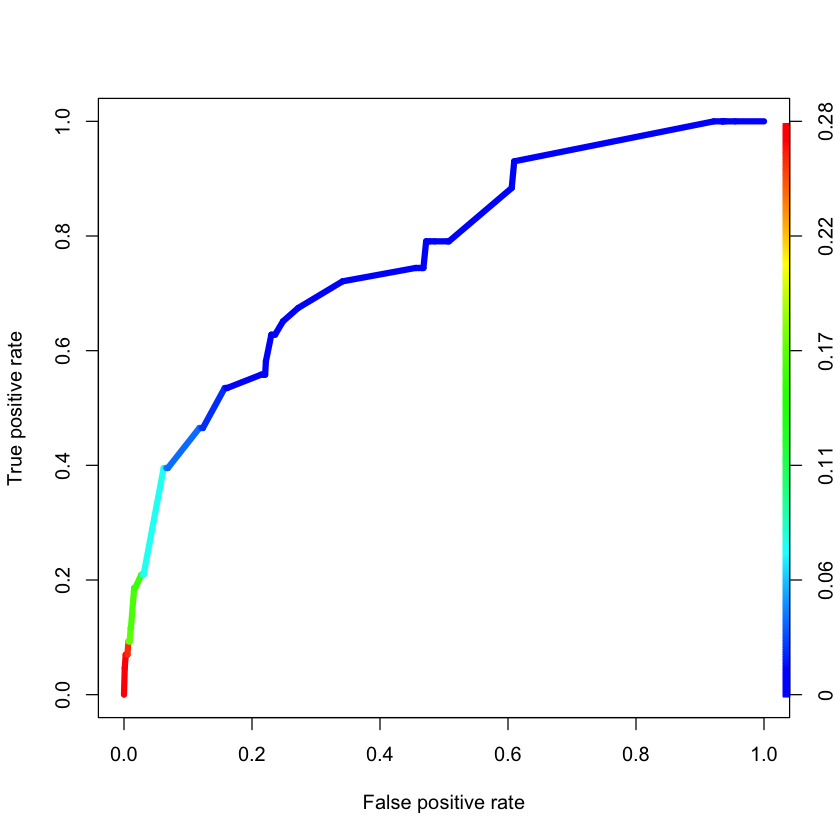

In [24]:
ROC_predict <- prediction(model_predict, test$fraud_status)
ROC_performance <- performance(ROC_predict, "tpr", "fpr")
plot(ROC_performance, colorize = TRUE, text.adj = c(-0.2,1.7), lwd = 5)


### Calculate the curve area value 

In [27]:
area_under_curve <- performance(ROC_predict, measure = "auc")


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.7626194


Slot "alpha.values":
list()


In [26]:
area_under_curve@y.values[[1]]


[1] 0.7626194

### Set training control parameter and use this model to predict the fraud status

In [30]:
ctrl <- trainControl(method = "repeatedcv", number = 10, savePredictions = TRUE)


In [31]:
model_fit <- caret::train(fraud_status ~ customer_status + ship_status + destination_int + 
                     Category_Level_2Clothing + num_valid ,
                   data = train, method = "glm", family = binomial(link ="logit"),
                   trControl = ctrl, tuneLength = 10)


In [32]:
pred <- predict(model_fit, newdata = select(test, -fraud_status))
pred

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [112] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [149] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [186] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [223] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [260] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [297] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [334] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [371] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [408] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [445] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [482] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [519] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [556] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [593] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [630] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [667] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [704] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [741] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [778] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [815] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [852] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [889] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [926] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [963] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1000] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1037] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1074] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1111] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1148] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1185] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1222] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1259] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1296] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1333] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1370] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1407] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1444] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1481] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1518] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1555] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1592] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1629] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1666] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1703] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1740] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1777] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1814] 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [33]:
conf <- confusionMatrix(data = pred, test$fraud_status)


In [34]:
conf

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2580   43
         1    0    0
                                         
               Accuracy : 0.9836         
                 95% CI : (0.978, 0.9881)
    No Information Rate : 0.9836         
    P-Value [Acc > NIR] : 0.5404         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : 1.504e-10      
                                         
            Sensitivity : 1.0000         
            Specificity : 0.0000         
         Pos Pred Value : 0.9836         
         Neg Pred Value :    NaN         
             Prevalence : 0.9836         
         Detection Rate : 0.9836         
   Detection Prevalence : 1.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         

In [35]:
conf$byClass

Sensitivity          Specificity       Pos Pred Value 
           1.0000000            0.0000000            0.9836066 
      Neg Pred Value            Precision               Recall 
                 NaN            0.9836066            1.0000000 
                  F1           Prevalence       Detection Rate 
           0.9917355            0.9836066            0.9836066 
Detection Prevalence    Balanced Accuracy 
           1.0000000            0.5000000